# **02_Data Visualization**

## Objectives

> Answer Business Requirements 1:
* The client is interested in conducting a study to visually differentiate a cherry leaf that is healthy from one that contains powdery mildew.

* Eventually resize images.

## Inputs

* inputs/dataset/cherry_leaves_dataset/cherry-leaves/test
* inputs/dataset/cherry_leaves_dataset/cherry-leaves/train
* inputs/dataset/cherry_leaves_dataset/cherry-leaves/validation


## Outputs

* Create answer for Business Requirements 1
* Image shape embeddings pickle file
* Mean and variability of images per label plot.
* Plots to differentiate between mildew-infected and uninfected leaves images.
* Create basis for an image montage on the Streamlit dashboard

---

# Set data directory

### Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

### Set working directory

Change the working directory from its current folder to its parent folder
> access the current directory with ```os.getcwd()```

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/PP5-mildew-detection/jupyter_notebooks'

Make the parent of the current directory the new current directory
> ```os.path.dirname()``` gets the parent directory; ```os.chir()``` defines the new current directory

In [ ]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [ ]:
current_dir = os.getcwd()
current_dir

'/workspaces/PP5-mildew-detection'

### Set input directories

Set train, validation an test paths.

In [8]:
my_data_dir = 'inputs/dataset/cherry_leaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

### Set output directory

In [9]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


### Set label names

In [10]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


---

# Data Visualization of image Data

---

## Image Shape

We will compute the averagge size on the train set

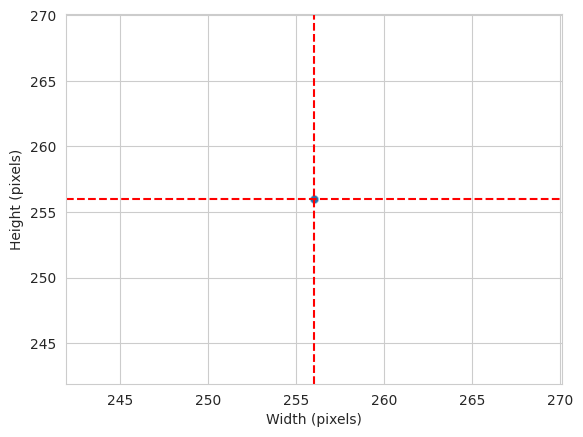

Width average: 256 
Height average: 256


In [11]:
# code for Data Visualization and its functions were adapted and taken from Walkthrough Project 01 Malaria Detector 
dim1, dim2 = [], []
for label in labels:
    for image_filename in os.listdir(train_path + '/' + label):
        img = imread(train_path + '/' + label + '/' + image_filename)
        d1, d2, colors = img.shape
        dim1.append(d1)  # image height
        dim2.append(d2)  # image width

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean, color='r', linestyle='--')
axes.axhline(y=dim2_mean, color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")

This shows that the average image width as well as the average image height is 256px. Which is the image size to train the model.
Below you can see the data regarding the image shape. The 256 numbers are already known to us. The third value dipicts the number of gradients - Red Green Blue Gradient (standard RGB colour range). 


In [12]:
image_shape = (dim1_mean, dim2_mean, 3)
image_shape

(256, 256, 3)

The image shape is saved in the outputs folder.

In [13]:
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

---

## Average and variability of images per label

### Function to load images in an array (tensor)

We will define the mean and standard deviation of pixel values within mildew-infected leaves pictures and noninfected leaves pictures.

For this we define the function ```load_image_as_array```. In it we will load the image data as well their labels into an array. 

In [19]:
# code for Data Visualization and its functions were adapted and taken from Walkthrough Project 01 Malaria Detector 
from tensorflow.keras.preprocessing import image


def load_image_as_array(my_data_dir, new_size=(50, 50), n_images_per_label=20):

    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(my_data_dir + '/' + label):
            # n_images_per_label: we set a limit, since it may take too much time
            if counter < n_images_per_label:

                img = image.load_img(
                    my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                X = np.append(X, img_resized).reshape(-1,
                                                      new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return X, y

Now we load our training data through this function into the variables ```X``` & ```y```.

In [20]:
X, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                           n_images_per_label=30)
print(X.shape, y.shape)



(60, 256, 256, 3) (60,)


### Plot and Save meand and variability of images per label

We define the function ```plot_mean_variability_per_labels``` in order to plot the mean and variability of images per mildew-infected- and healthy leaves images.

It takes the before defined ```X``` & ```y``` variables and the fig size. It loops over the labels and subsets of each label are created afterwards. Finally the meand and standard deviation is calculated. Images of them  are displayed and saved once the function is called.

In [ ]:
# code for Data Visualization and its functions were adapted and taken from Walkthrough Project 01 Malaria Detector 
def plot_mean_variability_per_labels(X, y, figsize=(12, 5), save_image=False):
    """
    The pseudo-code for the function is:
    * Loop over all labels
    * Subset an array for a given label
    * Calculate the mean and standard deviation
    * Create a figure displaying the mean and variability of images
    * Save the image
    """

    for label_to_display in np.unique(y):
        sns.set_style("white")

        y = y.reshape(-1, 1, 1)
        boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask]

        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for label {label_to_display}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for label {label_to_display}")
        axes[1].imshow(std_img, cmap='gray')

        if save_image:
            plt.savefig(f"{file_path}/avg_var_{label_to_display}.png",
                        bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")

We call the function ```plot_mean_variability_per_labels``` with our data & the average and variabiliy ids displayed and saved to the output folder.

==== Label healthy ====
Image Shape: (256, 256, 3)
==== Label powdery_mildew ====
Image Shape: (256, 256, 3)


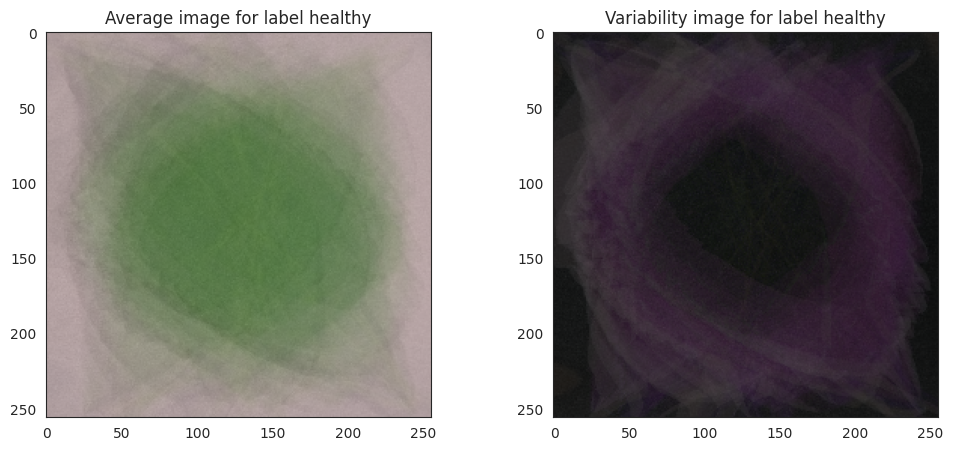

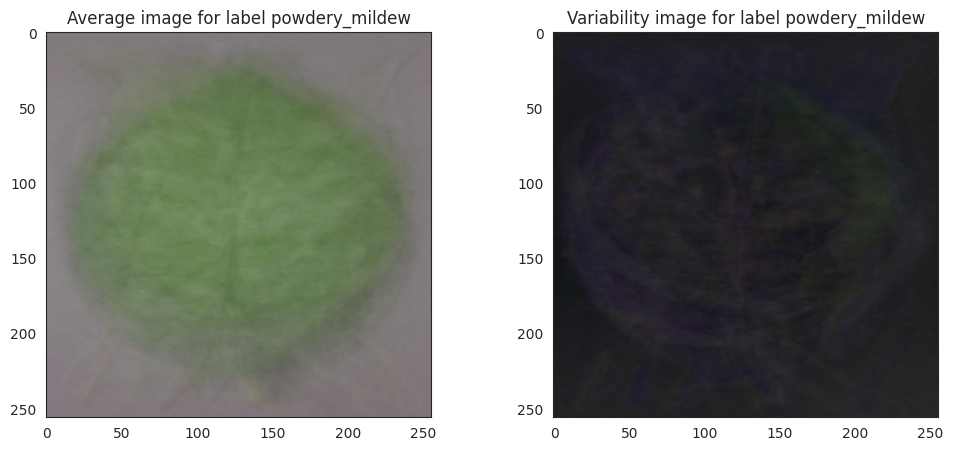

In [22]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(12, 5), save_image=True)

As can be seen the average image of mildew infected leaves is less highly greenly pigmeted. A light white top coat can be seen as well which is not present ine the average healthy leave image. 

# Section 2

Section 2 content

---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* If you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
    # create here your folder
    # os.makedirs(name='')
except Exception as e:
    print(e)
